In [6]:
# -- use this line at the beginning of your notebook to turn on interactive plots
#%matplotlib inline
%matplotlib notebook
#%matplotlib 
#%matplotlib ipympl

# Imports
import sys
import matplotlib.pyplot as plt  # plotting library
from matplotlib import colors
import numpy as np  # work with numeric arrays without labeled axes
import xarray as xr  # work with arrays with labeled axes
import xrscipy.signal as dsp  # xarray signal filtering etc.
import scipy as sps
from cdb_extras import xarray_support as cdbxr  # access to COMPASS Database (CDB)
import pickle # to save data
from pathlib import Path # to easily work with different files
from progressbar import ProgressBar
from typing import Optional, Union
from dataclasses import dataclass
from typing import Optional
plt.rcParams.update({'font.size': 14})

In [2]:
from core.pedestal_fit import PedestalParams, get_thomson_data, fit, pedestal_params_extraction
from core.sawtooth_extraction import ST_detector, ST_time_and_phase
from core.pedestal_ploting import load_pedestal_data, scatter_pedestal_params, get_ELM_ST_phase_and_duration

In [3]:
# Only use Thomson data from this normalized psi value and up
psi_n_lim = 0.6
savesaw="/compass/home/odlozilik/repos/ELM-Sawtooth/sawtooth_data"
saveped="/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals"

Using stray corrected data


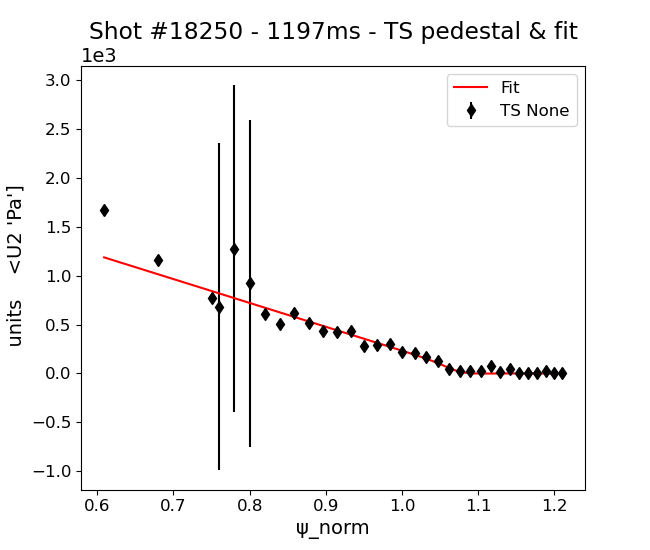

In [7]:
# Just for testing the fitting algorithm
if True: # Set to True and run this block of code to test the fitting algorithm
    shot_nr = 18250
    time = 1200
    ne, ne_err, Te, Te_err, pe, pe_err, psi_n, psi_n_fit_coords, t_H_mode_start, t_H_mode_end = get_thomson_data(shot_nr, psi_n_lim)
    d = pe.sel(time=time, method='nearest')
    e = pe_err.sel(time=time, method='nearest')
    psi_n_one = psi_n.sel(time=time, method='nearest')

    fit(data=d, error=e, psi_n=psi_n_one,psi_n_lim=psi_n_lim, shot_nr=shot_nr, plot=True)

In [6]:
pedestal_data_folder = Path(saveped)
pedestal_data_list = []

for item in pedestal_data_folder.iterdir():
    if item.is_file and item.suffix == ".bin":
        with open(item, 'rb') as fp:
            pedestal_data_list.append(pickle.load(fp))

In [6]:
ST_time_relative_to_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)
elm_duration_tot= np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    
    ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time = get_ELM_ST_phase_and_duration(d.shot_number, savesaw)
    
    ST_times = load_ST_crash_time(d.shot_number)
    ST_phase_in_ELM_period, ST_time_relative_to_ELM, elm_duration = ELM_phase(d.shot_number, ST_times, relative_to_nearest=True)
    ST_periods = np.diff(ST_times)
    ST_time_relative_to_ELM = ST_time_relative_to_ELM[1:]
    elm_duration = elm_duration[1:]
    # Filters
    
    mask1 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    mask2 = np.logical_and(mask1, elm_duration > 2.5)
    
    elm_duration_tot = np.concatenate((elm_duration_tot, elm_duration[mask2]))
    ST_time_relative_to_ELM_tot = np.concatenate((ST_time_relative_to_ELM_tot, ST_time_relative_to_ELM[mask2]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask2]))

    
elm_duration_tot = np.clip(elm_duration_tot, a_min=2.5, a_max=2.51)
    

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
plt.xlabel('ST period [ms]')
plt.ylabel('ST time relative to ELM crash [ms]')
plt.ylim((-1.8,1.8))
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(ST_periods_tot, ST_time_relative_to_ELM_tot, ax, ax_histx, ax_histy, c='C2')

NameError: name 'load_ST_crash_time' is not defined

In [7]:
#test=pedestal_params_extraction(18254, psi_n_lim,save_path=saveped)

# Create a list here of all the shots you want to extract pedestal parameters for.
shot_list = [18252,18254,18255,18257,18260,18261,18263,18266,18267,18273,18274,18275,18276,18277]
             
for shot_nr in shot_list:
    print(f"\n#### EXTRACTING PEDESTAL PARAMETERS FROM SHOT {shot_nr}\n")
    pedestal_params_extraction(shot_nr, psi_n_lim,save_path=saveped)



#### EXTRACTING PEDESTAL PARAMETERS FROM SHOT 18252



  0% (0 of 55) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Using stray corrected data
Number of H-mode intervals : 1


 27% (15 of 55) |######                  | Elapsed Time: 0:00:02 ETA:   0:00:20

KeyboardInterrupt: 

Text(0, 0.5, 'Pedestal pressure height [Pa]')

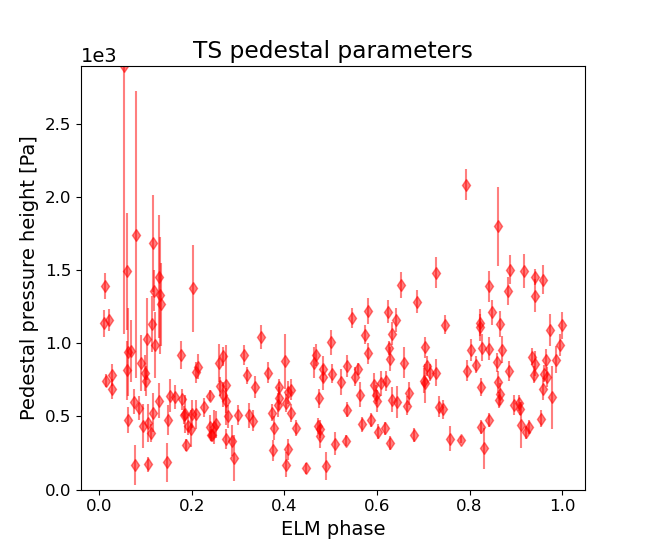

In [5]:
variable = 'pe' # One of 'pe', 'Te', 'ne'
parameter = 'height' # One of 'grad', 'height', 'width'

# Generate plots
scatter_pedestal_params(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals', x='ELM_phase', s=variable, p=parameter)
plt.xlabel('ELM phase')
plt.ylabel('Pedestal pressure height [Pa]')

In [8]:
scatter_pedestal_params(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals',x='ELM_time', s=variable, p=parameter)
plt.xlabel('Time after previous ELM [ms]')
plt.ylabel('Pedestal pressure height [Pa]')

NameError: name 'variable' is not defined

In [ ]:
scatter_pedestal_params(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals',x='ST_phase', s=variable, p=parameter)
plt.xlabel('TS phase')
plt.ylabel('Pedestal pressure height [Pa]')

In [ ]:
scatter_pedestal_params(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals',x='ST_time', s=variable, p=parameter)
plt.xlabel('Time to nearest sawtooth [ms]')
plt.ylabel('Pedestal pressure height [Pa]')

In [ ]:
ST_detector(18273, with_plots=True,save_path=savesaw)